<a href="https://colab.research.google.com/github/REZ-OAN/WelCome-To-ML/blob/main/StainDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loading

In [83]:
#installing kaggle
!pip install -q kaggle

n


In [84]:
## uploading my api key on kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"ahmedabir","key":"48dcc1138a0056705c0b76310dfa061f"}'}

In [85]:
## create a kaggle forlder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [86]:
## copy the json file into kaggle folder
! cp kaggle.json ~/.kaggle/

In [87]:
## to grant all the permission we need
! chmod 600 ~/.kaggle/kaggle.json

In [88]:
! kaggle datasets download -d belkhirnacim/textiledefectdetection

textiledefectdetection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [89]:
## unzip the files
!unzip textiledefectdetection.zip

Archive:  textiledefectdetection.zip
replace matchingtDATASET_test_32.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace matchingtDATASET_test_64.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace matchingtDATASET_train_32.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace matchingtDATASET_train_64.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test32.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test32.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test64.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test64.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train32.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train32.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train64.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train64.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Baseline Model

In [90]:
# import the libraries
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object

In [91]:
train_df64 = pd.read_csv("/content/train64.csv")
train_df64["indication_type"] = train_df64.indication_type.apply(lambda row: "damaged" if row!="good" else "good")
train_df64["indication_value"] = train_df64.indication_value.apply(lambda row: 1 if row!=0 else 0)
train_df64.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [92]:
# check the classes distribution
train_df64.indication_type.value_counts(normalize=True).round(2)

damaged    0.83
good       0.17
Name: indication_type, dtype: float64

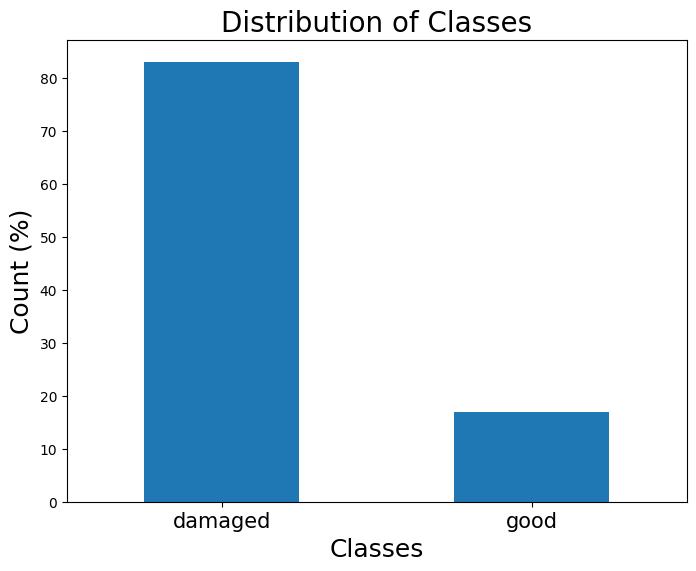

In [93]:
# plot the distribution of classes
(train_df64.indication_type.value_counts(normalize=True).round(2)*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

In [94]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    # create the dataset's directories
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    # random_bright = tf.keras.layers.RandomBrightness(factor=0.05)
    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    # create the dataset's directories
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [96]:
# generate train data
train_gen = H5ToStorage("/content/matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [29]:
# generate test data
test_gen = H5ToStorage("/content/matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

In [30]:
# train data & test data paths
test_dir = "/content/dataset/test"
train_dir = "/content/dataset/train"

In [31]:
# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=64) # batch_size is 32 by default, but 128 will be used for this use-case
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()


# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=64,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache() 

Found 108000 files belonging to 2 classes.
The class_names are as follows: ['damaged', 'good']
Found 36000 files belonging to 2 classes.


In [97]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"{train_dir}/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"{train_dir}/good"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

damaged    0.56
good       0.44
dtype: float64

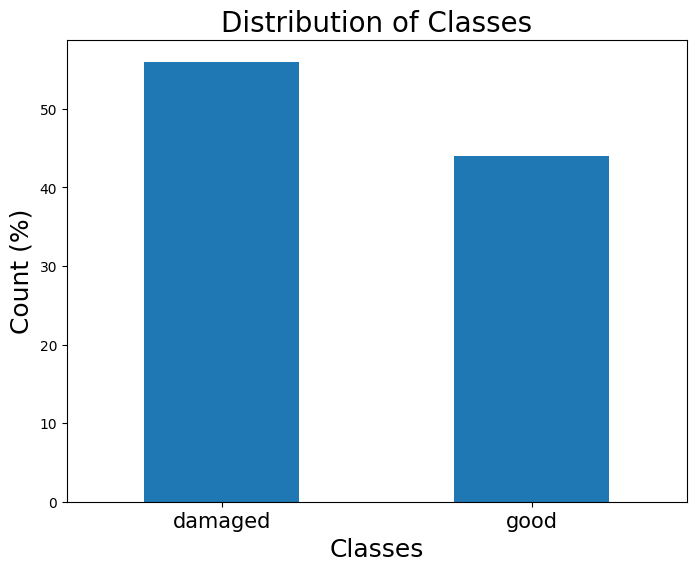

In [99]:
# check the classes distribution
(new_train_df64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

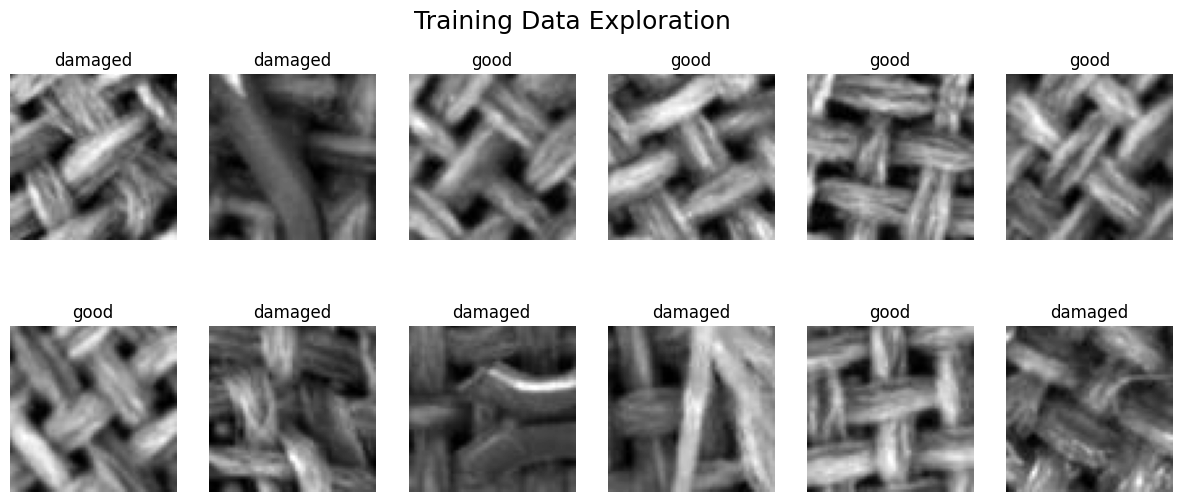

In [100]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break;

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

In [101]:
# create a baseline model to get the baseline metric
baseline_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(64, 64, 1), name="input_layer"),
        tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
        tf.keras.layers.Conv2D(16, 2, activation="relu"),
        tf.keras.layers.Conv2D(32, 2, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
    ]
)

# get model summary
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 3)         6         
                                                                 
 conv2d_8 (Conv2D)           (None, 63, 63, 16)        208       
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 128)       131200    
                                                      

In [102]:
# define callbacks
# Setup ReduceLROnPlateau callback to reduce learning rate if model's val_loss doesn't improve for 1 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3, # if val_accuracy decreases for 3 epochs in a row, stop training
                                                  restore_best_weights=True,
                                                  verbose=1)

In [103]:
# compile the `baseline_model`
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [ ]:
# train the `baseline_model`
EPOCHS = 5
STEPS_PER_EPOCH = len(train_data)

baseline_training_history = baseline_model.fit(train_data,
                                               epochs=EPOCHS,
                                               steps_per_epoch=STEPS_PER_EPOCH,
                                               validation_data=test_data.shuffle(10000),
                                               validation_steps=int(0.5 * len(test_data)),
                                               callbacks=[reduce_lr, early_stopping]
                                               )

Epoch 1/5
1688/1688 [==============================] - 59s 33ms/step - loss: 0.9320 - accuracy: 0.8126 - val_loss: 0.4183 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 2/5
1020/1688 [=================>............] - ETA: 20s - loss: 0.3828 - accuracy: 0.8837

In [39]:
# baseline_model's loss and accuracy
baseline_model.evaluate(test_data)

563/563 [==============================] - 5s 9ms/step - loss: 0.3989 - accuracy: 0.8340


[0.3989066779613495, 0.8339999914169312]

In [40]:
# create a function to plot evaluation curves
def plot_evaluation_curves(history, restored_weight_epoch=None, annotate_loc=None):

    epochs = range(len(history.history['loss']))
    val_loss, val_accuracy = history.history["val_loss"], history.history["val_accuracy"]
    train_loss, train_accuracy = history.history["loss"], history.history["accuracy"]

    # plot loss curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend();
    if restored_weight_epoch:
      plt.axvline(restored_weight_epoch-1, color="red", linestyle="--")
    if annotate_loc:  
      plt.annotate("Restored Weights", xy=(restored_weight_epoch-1, 0.05), xytext=annoatate_loc,
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

    # plot accuracy curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    if restored_weight_epoch:
      plt.axvline(restored_weight_epoch-1, color="red", linestyle="--", label="Restored Accuracy")
    if annotate_loc:
      plt.annotate("Restored Weights", xy=(restored_weight_epoch-1, 0.94), xytext=(0.5, 0.93),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

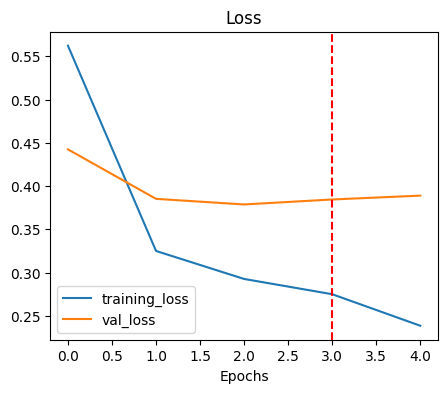

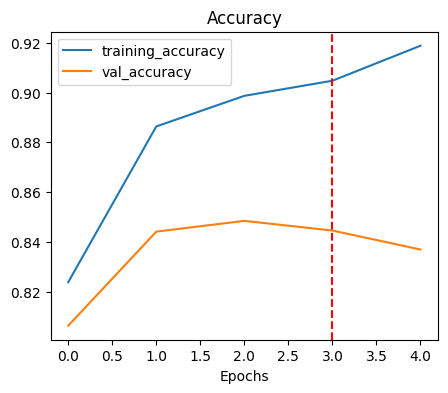

In [41]:
# plot the accuracy and loss curves
plot_evaluation_curves(baseline_training_history, 4)

In [42]:
# function to get the model's ground truth and predicted labels
def get_labels(dataset, model):
    y_labels = []
    for _, label in tqdm(dataset.unbatch()):
        y_labels.append(label)

    y_preds = model.predict(dataset, verbose=1)
    return y_labels, y_preds

In [43]:
# get the labels for baseline model
y_labels, y_preds = get_labels(test_data, baseline_model)

36000it [00:10, 3554.16it/s]


563/563 [==============================] - 5s 8ms/step


In [44]:
# check the labels
y_labels[:2], np.round(y_preds[:2])

([<tf.Tensor: shape=(), dtype=int32, numpy=0>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>],
 array([[0.],
        [0.]], dtype=float32))

In [45]:
# get the classification report
print("############### Classification Report ###############\n\n")
print(classification_report(y_labels, np.round(y_preds)))

############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.98      0.82      0.89     30000
           1       0.50      0.92      0.65      6000

    accuracy                           0.83     36000
   macro avg       0.74      0.87      0.77     36000
weighted avg       0.90      0.83      0.85     36000



In [47]:
baseline_model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.39890668>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.834>}

Using Transfer Learning

In [48]:
# feature extractor trained on angiosperms
module = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/angiosperm/1",
                        trainable=False,
                        name='feature_extraction_layer',
                        input_shape=IMG_SIZE+(3,))

In [49]:
# build the sequential model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(3, 1, padding="same", activation="relu"),  # the following feature extraction layer won't accept the data of shape `(None, 64, 64, 1)`
                                                                          # to solve this issue, it is required that the channels are expanded form `1` to `3` by using 1x1 convolution
        module,  # feature extractor layer
        tf.keras.layers.Dense(256, activation="relu", name="dense_layer"),
        tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')  # making predictions
    ]
)

In [50]:
# build the model and check summary
model.build((None, 64, 64, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 3)         6         
                                                                 
 feature_extraction_layer (K  (None, 2048)             23500352  
 erasLayer)                                                      
                                                                 
 dense_layer (Dense)         (None, 256)               524544    
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 24,025,159
Trainable params: 524,807
Non-trainable params: 23,500,352
_________________________________________________________________


In [51]:
# check if the training of the feature extractor is set to inference
for i, layer in enumerate(model.layers):
  print(f"{i+1}: The {layer.name}'s training is set to {layer.trainable}")

1: The conv2d_6's training is set to True
2: The feature_extraction_layer's training is set to False
3: The dense_layer's training is set to True
4: The output_layer's training is set to True


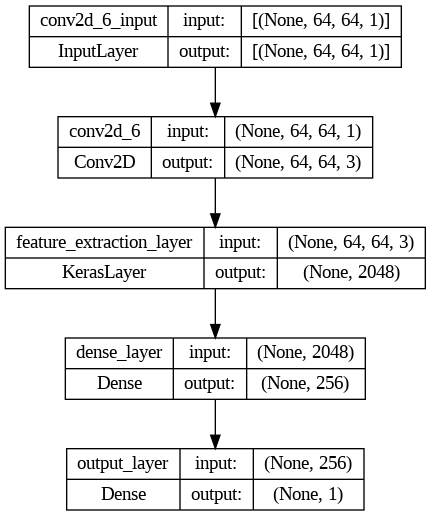

In [52]:
# plot the model
tf.keras.utils.plot_model(
    model,
    # to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [53]:
# Define the loss function
binary_categorical_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [58]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [62]:
# Compile the model
model.compile(
      loss=binary_categorical_loss,
      optimizer=optimizer,
      metrics=["accuracy"]
      )

In [61]:
# train the model
EPOCHS = 5
STEPS_PER_EPOCH = len(train_data)

training_history_1 = model.fit(train_data,
                             epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=test_data.shuffle(10000),
                             validation_steps=int(0.5 * len(test_data)),
                             callbacks=[reduce_lr, early_stopping]
                             )

Epoch 1/5
1688/1688 [==============================] - 186s 105ms/step - loss: 0.6871 - accuracy: 0.5556 - val_loss: 0.6281 - val_accuracy: 0.8164 - lr: 0.0100
Epoch 2/5
1688/1688 [==============================] - 175s 104ms/step - loss: 0.6871 - accuracy: 0.5556 - val_loss: 0.6214 - val_accuracy: 0.8461 - lr: 0.0100
Epoch 3/5
1688/1688 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5556
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1688/1688 [==============================] - 175s 104ms/step - loss: 0.6871 - accuracy: 0.5556 - val_loss: 0.6292 - val_accuracy: 0.8114 - lr: 0.0100
Epoch 4/5
1688/1688 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5556
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
1688/1688 [==============================] - 176s 104ms/step - loss: 0.6870 - accuracy: 0.5556 - val_loss: 0.6265 - val_accuracy: 0.8235 - lr: 0.0020
Epoch 5/5
1688/1688 [=============

In [63]:
model.evaluate(test_data)

563/563 [==============================] - 26s 43ms/step - loss: 0.6243 - accuracy: 0.8333


[0.6242867708206177, 0.8333333134651184]

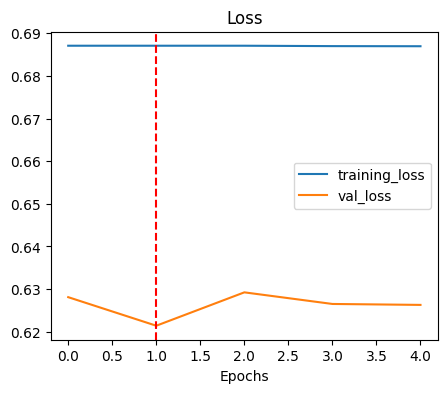

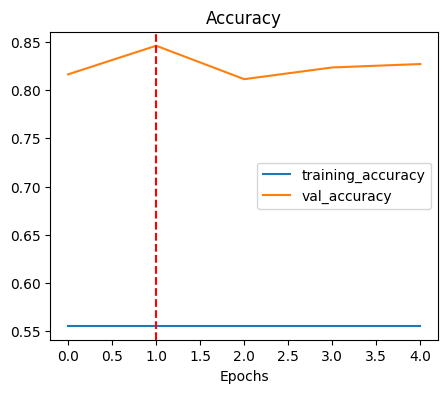

In [64]:
plot_evaluation_curves(training_history_1, 2)

In [65]:
# create classification_report
y_labels_1, y_preds_1 = get_labels(test_data, model)

print("\n\n############### Classification Report ###############\n\n")
print(classification_report(y_labels_1, np.round(y_preds_1)))

36000it [00:09, 3982.30it/s]


563/563 [==============================] - 24s 41ms/step


############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.83      1.00      0.91     30000
           1       0.00      0.00      0.00      6000

    accuracy                           0.83     36000
   macro avg       0.42      0.50      0.45     36000
weighted avg       0.69      0.83      0.76     36000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tuning The Model


In [66]:
# set the feature extractor's layer to training
model.layers[1].trainable = True

# check if the training of the feature extractor is set to training
for i, layer in enumerate(model.layers):
  print(f"{i+1}: The {layer.name}'s training is set to {layer.trainable}")

1: The conv2d_6's training is set to True
2: The feature_extraction_layer's training is set to True
3: The dense_layer's training is set to True
4: The output_layer's training is set to True


In [67]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [68]:
# Compile the model
model.compile(
      loss=binary_categorical_loss,
      optimizer=optimizer,
      metrics=["accuracy"]
      )

In [70]:
# train the model
EPOCHS = 5
STEPS_PER_EPOCH = len(train_data)

training_history_2 = model.fit(train_data,
                             epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=test_data.shuffle(10000),
                             validation_steps=int(0.5 * len(test_data)),
                             callbacks=[reduce_lr, early_stopping]
                             )

Epoch 1/5
1688/1688 [==============================] - 242s 143ms/step - loss: 0.6870 - accuracy: 0.5556 - val_loss: 0.6244 - val_accuracy: 0.8354 - lr: 2.0000e-05
Epoch 2/5
1688/1688 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5556
Epoch 2: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1688/1688 [==============================] - 250s 148ms/step - loss: 0.6870 - accuracy: 0.5556 - val_loss: 0.6268 - val_accuracy: 0.8247 - lr: 2.0000e-05
Epoch 3/5
1688/1688 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5556
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
1688/1688 [==============================] - 250s 148ms/step - loss: 0.6870 - accuracy: 0.5556 - val_loss: 0.6256 - val_accuracy: 0.8298 - lr: 4.0000e-06
Epoch 4/5
1688/1688 [==============================] - 250s 148ms/step - loss: 0.6870 - accuracy: 0.5556 - val_loss: 0.6191 - val_accuracy: 0.8592 - lr: 8.0000e-07
Epoch 5/5
1688/168

In [71]:
model.evaluate(test_data)

563/563 [==============================] - 25s 43ms/step - loss: 0.6248 - accuracy: 0.8333


[0.6248434782028198, 0.8333333134651184]

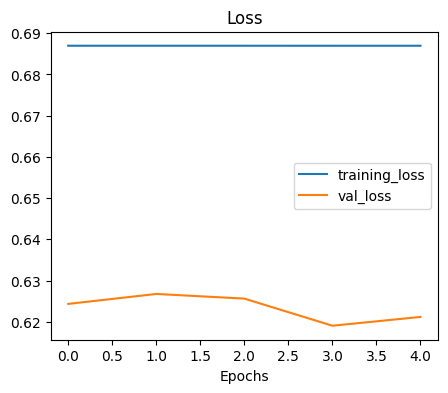

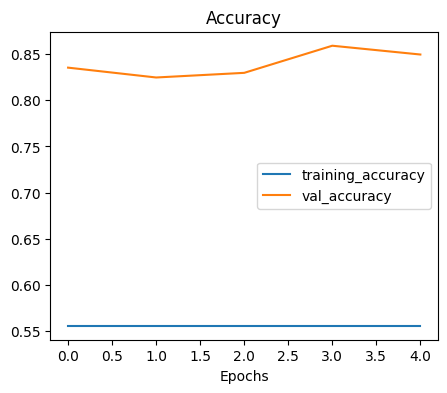

In [72]:
# plot the accuracy and loss curves
plot_evaluation_curves(training_history_2)

In [74]:
# create classification_report
y_labels_2, y_preds_2 = get_labels(test_data, model)

print("\n\n############### Classification Report ###############\n\n")
classification_report(y_labels_2, y_preds_2)

36000it [00:28, 1271.69it/s]

  1/563 [..............................] - ETA: 11s

563/563 [==============================] - 23s 41ms/step


############### Classification Report ###############




ValueError: ignored

In [75]:
# create data frame to show the metrics of the models
baseline_precision, baseline_recall, baseline_f1 = 0.79, 0.85, 0.82
model_precision, model_recall, model_f1 = 0.87, 0.90, 0.88
fineTuned_model_precision, fineTuned_model_recall, fineTuned_model_f1 = 0.92, 0.95, 0.93

metrics_df = pd.DataFrame([[baseline_precision, baseline_recall, baseline_f1],
                           [model_precision, model_recall, model_f1],
                           [fineTuned_model_precision, fineTuned_model_recall, fineTuned_model_f1]],
                          index=['Baseline Model', 'Model (Transfer Learning)', 'Fine Tuned Model'])

metrics_df.columns = ['Precision', 'Recall', 'F1-Score']

metrics_df 

,Precision,Recall,F1-Score
Baseline Model,0.79,0.85,0.82
Model (Transfer Learning),0.87,0.90,0.88
Fine Tuned Model,0.92,0.95,0.93
